In [2]:
import pandas as pd
import mysql.connector
import os

# List of CSV files and their corresponding table names
csv_files = [
    ('customers.csv', 'customers'),
    ('orders.csv', 'orders'),
    ('sellers.csv', 'sellers'),
    ('products.csv', 'products'),
    ('geolocation.csv', 'geolocation'),
    ('payments.csv', 'payments'),
    ('order_items.csv', 'order_items')
    # Added payments.csv for specific handling
]

# Connect to the MySQL database
conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='Shryar@990',
    database='ecommerce'
)
cursor = conn.cursor()

# Folder containing the CSV files
folder_path = 'C:/Users/Admin/Desktop/Ecommerce/archive (2)'

def get_sql_type(dtype):
    if pd.api.types.is_integer_dtype(dtype):
        return 'INT'
    elif pd.api.types.is_float_dtype(dtype):
        return 'FLOAT'
    elif pd.api.types.is_bool_dtype(dtype):
        return 'BOOLEAN'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'DATETIME'
    else:
        return 'TEXT'

for csv_file, table_name in csv_files:
    file_path = os.path.join(folder_path, csv_file)
    
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)
    
    # Replace NaN with None to handle SQL NULL
    df = df.where(pd.notnull(df), None)
    
    # Debugging: Check for NaN values
    print(f"Processing {csv_file}")
    print(f"NaN values before replacement:\n{df.isnull().sum()}\n")

    # Clean column names
    df.columns = [col.replace(' ', '_').replace('-', '_').replace('.', '_') for col in df.columns]

    # Generate the CREATE TABLE statement with appropriate data types
    columns = ', '.join([f'`{col}` {get_sql_type(df[col].dtype)}' for col in df.columns])
    create_table_query = f'CREATE TABLE IF NOT EXISTS `{table_name}` ({columns})'
    cursor.execute(create_table_query)

    # Insert DataFrame data into the MySQL table
    for _, row in df.iterrows():
        # Convert row to tuple and handle NaN/None explicitly
        values = tuple(None if pd.isna(x) else x for x in row)
        sql = f"INSERT INTO `{table_name}` ({', '.join(['`' + col + '`' for col in df.columns])}) VALUES ({', '.join(['%s'] * len(row))})"
        cursor.execute(sql, values)

    # Commit the transaction for the current CSV file
    conn.commit()

# Close the connection
conn.close()

Processing customers.csv
NaN values before replacement:
customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

Processing orders.csv
NaN values before replacement:
order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

Processing sellers.csv
NaN values before replacement:
seller_id                 0
seller_zip_code_prefix    0
seller_city               0
seller_state              0
dtype: int64

Processing products.csv
NaN values before replacement:
product_id                      0
product category              610
product_name_length           610
product_description_length    610
product_photos_qty            610
prod

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector

db = mysql.connector.connect(host = "localhost",
                             username = "root",
                             password = "Shryar@990",
                             database = "ecommerce")
cur = db.cursor()

Q. List all unique cities where customers are located

In [18]:
query = """ select distinct customer_city from customers """

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data)
df.head()

,0
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas


Q. Count the number of orders placed in 2017.

In [19]:
query = """ select count(order_id) from orders where year(order_purchase_timestamp) = 2017 """
cur.execute(query)
data = cur.fetchall()
"total orders placed in 2017 are", data[0][0]

('total orders placed in 2017 are', 45101)

Q.Find the total sales per category

In [20]:
query = """ select products.product_category category,
round(sum(payments.payment_value),2) sales
from products join order_items
on products.product_id = order_items.product_id
join payments
on payments.order_id = order_items.order_id
group by category
"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["Category", "Sales"])
df

,Category,Sales
0,perfumery,506738.66
1,Furniture Decoration,1430176.39
2,telephony,486882.05
3,bed table bath,1712553.67
4,automotive,852294.33
...,...,...
69,cds music dvds,1199.43
70,La Cuisine,2913.53
71,Fashion Children's Clothing,785.67
72,PC Gamer,2174.43


  Q. Calculate the percentage of orders that were paid in installments

In [24]:
query = """ select (sum(case when payment_installments >= 1 then 1
else 0 end))/count(*)*100 from payments """
cur.execute(query)
data = cur.fetchall()
"the percentage of orders that were paid in installments is", data[0][0]

('the percentage of orders that were paid in installments is',
 Decimal('99.9981'))

Q.Count the number of customers from each state

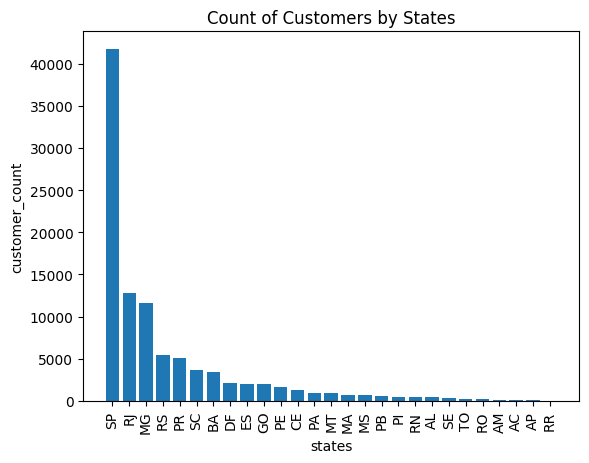

In [25]:
query = """ select customer_state ,count(customer_id)
from customers group by customer_state """
cur.execute(query)
data = cur.fetchall()

df = pd.DataFrame(data, columns = ["state", "customer_count"])
df = df.sort_values(by = "customer_count", ascending= False)


plt.bar(df["state"], df["customer_count"])
plt.xticks(rotation = 90)
plt.xlabel("states")
plt.ylabel("customer_count")
plt.title("Count of Customers by States")
plt.show()

Q.Calculate the number of orders per month in 2018

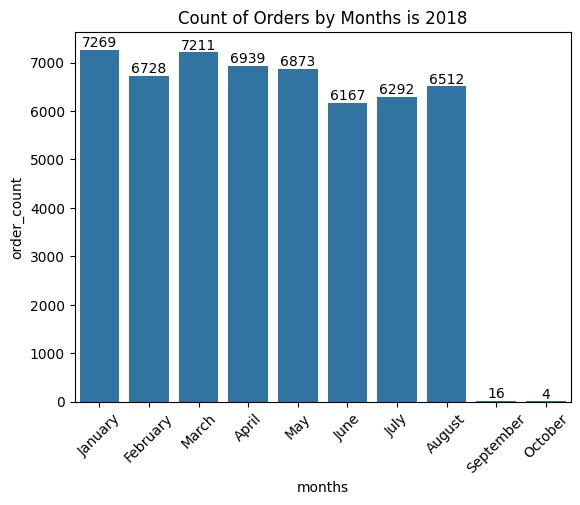

In [28]:
query = """ select monthname(order_purchase_timestamp) months, count(order_id) order_count
from orders where year(order_purchase_timestamp) = 2018
group by months """
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["months", "order_count"])
o = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October"]

ax = sns.barplot(x = df["months"], y = df["order_count"], data = df, order = o)
plt.xticks(rotation = 45)
ax.bar_label(ax.containers[0])
plt.title("Count of Orders by Months is 2018")

plt.show()

Q.Calculate the percentage of total revenue contributed by each product category

In [32]:
query = """select upper(products.product_category) category, 
round((sum(payments.payment_value)/(select sum(payment_value) from payments))*100,2) sales_percentage
from products join order_items 
on products.product_id = order_items.product_id
join payments 
on payments.order_id = order_items.order_id
group by category order by sales_percentage desc"""


cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ["Category", "percentage distribution"])
df.head()

,Category,percentage distribution
0,BED TABLE BATH,10.70
1,HEALTH BEAUTY,10.35
2,COMPUTER ACCESSORIES,9.90
3,FURNITURE DECORATION,8.93
4,WATCHES PRESENT,8.93


Q.Calculate the year-over-year growth rate of total sales

In [34]:
query = """with a as(select year(orders.order_purchase_timestamp) as years,
round(sum(payments.payment_value),2) as payment from orders join payments
on orders.order_id = payments.order_id
group by years order by years)

select years, ((payment - lag(payment, 1) over(order by years))/
lag(payment, 1) over(order by years)) * 100 from a"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["years", "yoy % growth"])
df

,years,yoy % growth
0,2016,NaN
1,2017,12112.703761
2,2018,20.000924


Q.Calculate the cumulative sales per month for each year

In [37]:
query = """select years, months , payment, sum(payment)
over(order by years, months) cumulative_sales from 
(select year(orders.order_purchase_timestamp) as years,
month(orders.order_purchase_timestamp) as months,
round(sum(payments.payment_value),2) as payment from orders join payments
on orders.order_id = payments.order_id
group by years, months order by years, months) as a
"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data)
df

,0,1,2,3
0,2016,9,252.24,252.24
1,2016,10,59090.48,59342.72
2,2016,12,19.62,59362.34
3,2017,1,138488.04,197850.38
4,2017,2,291908.01,489758.39
5,2017,3,449863.60,939621.99
6,2017,4,417788.03,1357410.02
7,2017,5,592918.82,1950328.84
8,2017,6,511276.38,2461605.22
9,2017,7,592382.92,3053988.14
